In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
class platform:
    def __init__(self, N = 5000, steps = 1, controlarr = np.array(range(-1100,1200,100)), maxX = 0.015, minX = 0.001):
        # 平台模拟对象的构造函数
        # 支持设置输入的步数 step
        # 支持传入控制力差分量序列 controlarr
        # 支持传入两个阈值项maxX minX
        
        self.GoodReward = 50
        self.BadReward = -20
        self.NormalReward = 1
        # 一些打分量，可以自行修改
        
        self.steps = steps;
        # 读取的状态步数，1表示只读取当前时刻的状态向量，2表示当前加上前一刻的状态
        
        self.fg = 2
        # 与matlab版程序的fg含义相同，但是要注意是从0开始的
        
        self.h = 10
        # 时延项
        
        self.N = N
        # 时间步数，可以在训练的时候适当缩短来避免无意义的训练部分，比如从一定长度开始就已经只会输出50000，-50000N的力
        
        self.maxX = maxX
        self.minX = minX
        # 截留一些阈值
        
        self.controlarr = controlarr
        # 保存一下离散的控制力差分量
        
        self.n_actions = controlarr.shape[0]
        # 记录一下控制力差分量的可选个数
        
        self.n_features = steps * 4 + 1
        # 网络的输入维度 4 * 步数 + 1，那个多出的1是归一化后的控制力，位于输入的最后一维，即[-50000,50000] => [-1, 1]
        
        raw_data = sio.loadmat('waveforce081228.mat')
        # 只需要是那个包含了f矩阵的.mat文件即可，f矩阵表示了若干个时刻下的随机波浪力
        
        self.matA = np.array([0.9998, 0.0000, 0.0100, 0.0000,0.0003, 0.9997, 0.0000 ,0.0100,-0.0486, 0.0003, 0.9980, 0.0000,0.0541, -0.0542, 0.0046, 0.9954]).reshape([4, 4])
        # 对应于原matlab代码中的A B D B1 Bc Dc Ac矩阵
        # 用matlab在给定平台和AMD参数后运行一遍simulation.m后即可得到各个矩阵的值
        # 如果matlab里面的平台参数没变此处可以保留，已经严格检验过正确性
        
        self.matB = np.array([0.0004,-0.0811,-0.0043,0.8580]).reshape([4, 1])
        self.matB = self.matB * 1e-6

        self.matD = np.array([0.0021,0.0000,0.4213,0.0010]).reshape([4, 1])
        self.matD = self.matD * 1e-8

        self.matB1 = np.array([-0.0000,0.0042,-0.0042,0.8416]).reshape([4, 1])
        self.matB1 = self.matB1 * 1e-6

        self.matBc = np.array([0,0,-0.0042,0.8435]).reshape([4, 1])
        self.matBc = self.matBc * 1e-4

        self.matDc = np.array([0,0,0.4217,0]).reshape([4, 1])
        self.matDc = self.matDc * 1e-6

        self.matAc = np.array([0,0,1.0000,0,
                            0,0,0,1.0000,
                            -4.8671,0.0271,-0.1782,0.0022,
                            5.4289,-5.4289,0.4343,-0.4343]).reshape([4, 4])

        
        self.matx = np.zeros([4, self.N, 4])
        self.mata = np.zeros([1, self.N, 4])
        self.matz = np.zeros([4, self.N, 4])
        self.matu = np.zeros([1, self.N, 4])
        # 对应于matlab中的x a z u四部分矩阵
        # 为了方便后续代码直接移植，所以可能多开辟了一些空间，但是方便后面的下标对应
    
        # self.matf = np.array(raw_data['f'])
        # 存储随机波浪力，该步骤被分解为两步，在init过程中只保留完整序列，在reset过程中进行起点的随机选择
        self.rawf = np.array(raw_data['f'])
        self.matf = np.zeros([1,self.N])
        

    def reset(self):
        # 这是进行一个episode前的准备步骤
        # 将记录平台历史状态的数组清空
        # 将每个step中做出的选择的记录清空
        
        # 2019/6/9 增加了一个功能 利用该功能可以让每次读入的序列有所不同
        # 即在每次reset的时候选取f序列中随机的某处作为起点(前提是f序列的长度要长于N)
        
        matf_minindex = 0
        matf_maxindex = self.rawf.shape[1] - self.N
        # startindex ∈[matfminindex, matfmaxindex]
        
        if matf_maxindex < matf_minindex:
            print('Error, f mat is too short!')
            return
        
        matf_startindex = random.randint(matf_minindex, matf_maxindex)
        
        self.matf = self.rawf[0,matf_startindex:matf_startindex + self.N].reshape([1, self.N])
        
        self.matx = np.zeros([4, self.N, 4])
        self.mata = np.zeros([1, self.N, 4])
        self.matz = np.zeros([4, self.N, 4])
        self.matu = np.zeros([1, self.N, 4])
        # 将历史状态数组置0
        
        self.k = self.h
        # 这个k是指向当前时刻的游标，由于时延的关系就直接设置为了h
        
        self.force = 0
        # 这个是当前的控制力
    
        self.forcev = 0
        # 这个是当前的控制力变化速度
        # 当用到二阶加速度时可能会用到这个量
        
        returnvalue = self.matz[:, self.k-self.steps+1:self.k+1, self.fg].reshape([n_features-1])
        returnvalue = np.append(returnvalue, self.force/50000)
        # 这里是初始化了第一个时刻接收到的状态序列，并拼接上了归一化的控制力
        # 注意[n_features - 1]是因为n_features里面包含了那个控制力的维度，所以要减1才能对应的上steps步 * 4个维度
        return returnvalue
    
    def showlast(self):
        # 打印最近一个episode中平台的状态表现
        # 本实验中我无法分辨x 和 z到底用哪个，因此做个说明
        # 所有展示用的都是x矩阵中的状态量
        # 所有涉及计算过程的都是用的z矩阵中的状态量
        # 有问题请自行修改
        
        plt.plot(range(0,self.k),self.matx[0,range(0,self.k),self.fg])
        plt.show()
        # 打印偏移
        # plot功能在jupyter下启动需要加 %matplotlib inline，已经加在前面了
        
        
        plt.plot(range(0,self.k),self.matu[0,range(0,self.k),self.fg])
        plt.show()
        # 打印控制力输出
        
    def save_status(self, str):
        # 指定名称保存某个episode中的平台状态历史记录，也即模型表现，可以保存为.mat
        
        sio.savemat(str,{'x':self.matx,'a':self.mata,'z':self.matz,'u':self.matu})
        # 保存了x a z u四个矩阵，matlab下可以正常读取
        
    def maxabsx(self):
        # 用于计算平台在上一个episode中的最大偏移值
        
        return np.max(np.abs(self.matx[0,:,]))
        # 注意这里好像没有指定fg,但是应该不影响效果
    
    def stdx(self):
        # 同上 用于计算平台在上一个episode中的均方差
        
        xs = self.matx[0,:,self.fg]
        # 注意这里需要指定第三个维度为fg
        
        xs = xs - np.mean(xs)
        xs = np.multiply(xs, xs)
        xs = np.sum(xs)
        xs = np.sqrt(xs / self.N)
        return xs
    
    
    def step(self, action):
        # 接受控制
        # 返回状态和即时奖励
        
        deltav = self.controlarr[action]
        # 这里是用action游标指定要采用第几个差分量
        
        # self.forcev = self.forcev + deltav
        # self.force = self.force + self.forcev
        # 用二阶差分量方法时采用这里的代码
        
        self.force = self.force + deltav
        # 使用一阶差分量来进行控制力的变化
        
        if self.force > 50000:
            self.force = 50000
        elif self.force < -50000:
            self.force = -50000
        # 控制力的上下截断

        self.matu[:, self.k, self.fg] = self.force
        # 将控制力保存在第k步
        # 为了不混淆，我们认为现在是在第k步
        self.matz[:, self.k + 1, self.fg] = self.matA @ self.matz[:, self.k, self.fg] + self.matB @ self.matu[:, self.k, self.fg] + self.matD @ self.matf[:, self.k]
        # 根据第k步的控制力计算出第 k + 1 步时的状态(供计算用)
        
        sumdelayu = np.zeros([1, 1])# strange
        for ik in range(self.k - self.h, self.k):
            Ak_ik_1 = np.eye(list(self.matA.shape)[0])
            A_h = np.eye(list(self.matA.shape)[0])
            for i in range(0, self.k-ik-1):
                Ak_ik_1 = Ak_ik_1 @ self.matA
            for i in range(0, self.h):
                A_h = A_h @ np.linalg.inv(self.matA)
            sumdelayu = sumdelayu + Ak_ik_1 @ A_h @ self.matB1 @ self.matu[:, ik, self.fg]
        self.matx[:, self.k, self.fg] = self.matz[:, self.k, self.fg] - sumdelayu
        # 含时滞项的计算(算出来的状态供展示用)
        # 虽然能区分z系统和x系统，但是依然不能明白为什么要分开为两个系统进行计算
        # 实际部署时明明只会有一个外部环境系统
        # 另外前面一段中matz的时间下标与matx的时间下标不一致，不知道有没有弄错
        # 再另外，如果担心该数值计算过程出错，可以自己比照原MATLAB代码
        
        self.mata[:, self.k, self.fg] = np.array([[0, 0, 1, 0]]) @ (self.matAc @ self.matx[:, self.k, self.fg] + self.matBc @ self.matu[:, self.k - self.h, self.fg] + self.matDc @ self.matf[:, self.k])
        # 计算加速度
                                                                                                          
        self.k = self.k + 1
        # 游标往前移动一位，这样返回的就是下一步的状态了
        
        returnvalue = self.matz[:, self.k-self.steps+1:self.k+1, self.fg].reshape([n_features-1])
        returnvalue = np.append(returnvalue, self.force/50000)
        # 截取下一步状态量（包含共steps步的状态）并拼上一个归一化控制力值
        
        
        # 以下是奖励设置与返回部分
        if self.k == self.N - 1:
            # 过完了N步，一个episode结束
            # 返回值中的True用来驱动学习体进行反向传播调参
            return returnvalue,  self.NormalReward, True,           "zzz"          
            #      返回状态序列，奖励值，           是否结束的标记，备用描述字符串
            
        if abs(self.matz[0, self.k, self.fg]) > self.maxX and abs(self.matz[0, self.k - 2, self.fg]) <= self.maxX:
            # 表示第k + 1步的偏移，在第k步的控制力作用下开始超出了阈值（注意是开始超出，所以后面又加了一个条件）
            return returnvalue, self.BadReward, False, "zzz"
        
        if abs(self.matz[0, self.k, self.fg]) < self.minX and abs(self.matz[0, self.k - 2, self.fg]) >= self.minX:
            # 表示.......................................开始小于阈值
            return returnvalue, self.GoodReward, False, "zzz" 
        
        if abs(self.matz[0, self.k, self.fg] - self.matz[0, self.k - 1, self.fg]) <= 2e-6:
            # 表示.........的瞬时Δx小于某阈值(也即速度，但是很奇怪的是matz[1,:,:]的计算有时会出错导致没法用)
            return returnvalue, self.GoodReward, False, "zzz" 
        
        if abs(self.matz[0, self.k, self.fg]) > self.maxX:
            # 表示.......................................持续高于阈值
            return returnvalue, self.BadReward/10, False, "zzz" 
        
        return returnvalue, self.NormalReward, False, "zzz" 
        # 表示现在正处于一般振动情况


In [2]:
"""
This part of code is the reinforcement learning brain, which is a brain of the agent.
All decisions are made in here.
Policy Gradient, Reinforcement Learning.
Using:
Tensorflow: 1.4
gym: 0.8.0
"""

import numpy as np
import tensorflow as tf

# reproducible
# 这个过程是为了让结果可复现
np.random.seed(1)
tf.set_random_seed(1)

class PolicyGradient:
    # 强化学习的学习体，其原始版本位于
    # https://github.com/princewen/tensorflow_practice/blob/master/RL/Policy_Gradient/RL_brain.py
    # 因为仅在其实现上做了少量修改，故注释极少
    
    def __init__(self,
                 n_actions,
                 n_features,
                 learning_rate = 0.0001,
                 reward_decay = 0.99,
                 output_graph = False):
        
        
        
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay

        self.ep_obs,self.ep_as,self.ep_rs = [],[],[]

        self._build_net()

        self.sess = tf.Session()

        if output_graph:
            tf.summary.FileWriter("logs/",self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def save_checkpoint(self):
        # 该方法可以保存整个计算图以及当前的参数，主要是网络参数
        # 可随时调用
        saver = tf.train.Saver(max_to_keep=3)
        saver.save(self.sess, 'my-model', global_step=0)

    def load_checkpoint(self):
        # 该方法可以将整个计算图中的参数加载回来
        # 但是这个写法只能维持一个计算图副本
        # 随时调用都可以
        saver = tf.train.Saver(max_to_keep=3)
        saver.restore(self.sess, 'my-model'+ '-' + str(0))
        
    def _build_net(self):
        with tf.name_scope('inputs'):
            self.tf_obs = tf.placeholder(tf.float32,[None,self.n_features],name='observation')
            self.tf_acts = tf.placeholder(tf.int32,[None,],name='actions_num')
            self.tf_vt = tf.placeholder(tf.float32,[None,],name='actions_value')

        layer = tf.layers.dense(
            inputs = self.tf_obs,
            units = 20,
            activation= tf.nn.relu,
            kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.3),
            bias_initializer= tf.constant_initializer(0.1),
            name='fc1'
        )
        
        layer2 = tf.layers.dense(
            inputs = layer,
            units = 20,
            activation= tf.nn.relu,
            kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.3),
            bias_initializer= tf.constant_initializer(0.1),
            name='fc2'
        )
        
        layer3 = tf.layers.dense(
            inputs = layer2,
            units = 20,
            activation= tf.nn.relu,
            kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.3),
            bias_initializer= tf.constant_initializer(0.1),
            name='fc3'
        )
        
        layer4 = tf.layers.dense(
            inputs = layer3,
            units = 20,
            activation= tf.nn.relu,
            kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.3),
            bias_initializer= tf.constant_initializer(0.1),
            name='fc4'
        )

        layer5 = tf.layers.dense(
            inputs = layer4,
            units = 20,
            activation= tf.nn.relu,
            kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.3),
            bias_initializer= tf.constant_initializer(0.1),
            name='fc5'
        )
        
        all_act = tf.layers.dense(
            inputs = layer5,
            units = self.n_actions,
            activation = None,
            kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.3),
            bias_initializer = tf.constant_initializer(0.1),
            name='fc6'
        )

        self.all_act_prob = tf.nn.softmax(all_act,name='act_prob')

        with tf.name_scope('loss'):
            #neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.all_act_prob,labels =self.tf_acts)

            neg_log_prob = tf.reduce_sum(-tf.log(self.all_act_prob) * tf.one_hot(indices=self.tf_acts,depth=self.n_actions),axis=1)
            loss = tf.reduce_mean(neg_log_prob * self.tf_vt)


        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)



    def choose_action(self,observation):
        prob_weights = self.sess.run(self.all_act_prob,feed_dict={self.tf_obs:observation[np.newaxis,:]})
        action = np.random.choice(range(prob_weights.shape[1]),p=prob_weights.ravel())
        return action


    def store_transition(self,s,a,r):
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_rs.append(r)


    def learn(self):
        discounted_ep_rs_norm = self._discount_and_norm_rewards()

        self.sess.run(self.train_op,feed_dict={
            self.tf_obs:np.vstack(self.ep_obs),
            self.tf_acts:np.array(self.ep_as),
            self.tf_vt:discounted_ep_rs_norm,
        })

        self.ep_obs,self.ep_as,self.ep_rs = [],[],[]
        return discounted_ep_rs_norm



    def _discount_and_norm_rewards(self):
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        # reserved 返回的是列表的反序，这样就得到了贴现求和值。
        for t in reversed(range(0,len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add
        
        discounted_ep_rs = discounted_ep_rs - np.mean(discounted_ep_rs)
        discounted_ep_rs = discounted_ep_rs / np.std(discounted_ep_rs)
        return discounted_ep_rs


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from my-model-0
maxscore updated: 659.0
minabsx updated: 0.014989781538415682
episode: 0   reward: 659.0
showing...


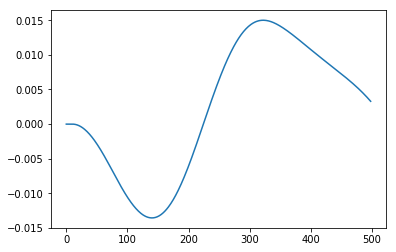

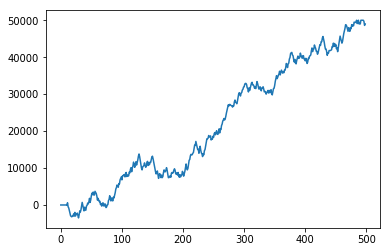

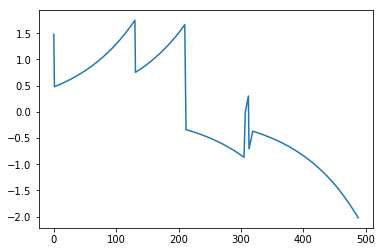

In [3]:
"""
Policy Gradient, Reinforcement Learning.
The cart pole example
Using:
Tensorflow: 1.0
gym: 0.8.0
"""
%matplotlib inline
import gym
import matplotlib.pyplot as plt

env = platform(N = 500, steps=3)
# 初始化平台对象
# 但是实际上存在一个问题，该代码缺乏波浪力的随机生成过程，一直在用同一组波浪力...
# 实在没办法可以先自己弄一堆波浪力文件，然后在env.reset()过程中进行随机选取

n_actions = env.n_actions
n_features = env.n_features

RL = PolicyGradient(
    n_actions=n_actions,
    n_features = n_features,
    learning_rate = 0.001,
    reward_decay = 0.99
)

maxscore = -999999
minmaxabsx = 2.4
minstdx = 0.007
# 模型表现效果的阈值

RL.load_checkpoint()

for i_episode in range(1):
    # episode数
    # 未设计模型暂存与加载功能，可以自己按照需求添加，相关方法已经提供了
    
    observation = env.reset()
    # 重置平台对象
    
    while True:
        
        action = RL.choose_action(observation)
        # 根据随机概率列选择动作
        observation_,reward,done,info = env.step(action)
        # 将动作送给平台对象，然后得到状态返回值
        RL.store_transition(observation,action,reward)
        # 调用学习体的存储方法

        if done:
            # 一轮学习完成后
            ep_rs_sum = sum(RL.ep_rs)
            # 将每步的得分累和
            
            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                # 用一个公式计算模型当前得分
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            if running_reward > maxscore:
                # 当得分高的时候，将模型的表现保存下来
                maxscore = running_reward
                print('maxscore updated:', running_reward)
                env.save_status('maxscore.mat')
            
            
            tmpval = env.maxabsx()
            if tmpval < minmaxabsx:
                # 当偏移最大值达到最小时暂存模型表现
                minmaxabsx = tmpval
                print('minabsx updated:', tmpval)
                env.save_status('minabsx.mat')
                
            tmpval = env.stdx()
            if tmpval < minstdx:
                # 同理
                minstdx = tmpval
                print('minstdx updated:', tmpval)
                env.save_status('minstdx.mat')
                
            print("episode:", i_episode, "  reward:", running_reward)
            # 打印该轮的数值表现，可扩充
            
            vt = RL.learn()
            # 调用学习体的调参方法进行参数更新
            
            if i_episode % 100 == 0:
                # 每100轮打印一下模型效果
                print("showing...")
                env.showlast()
                # 这个是平台历史状态的图
                
                plt.plot(vt)
                plt.show()
                # 这个是每步得分的图
                
            break
            
        observation = observation_
        # observation 和 observation_的逻辑关系请自己理一下
        
RL.save_checkpoint()

In [4]:
# TODO
# PACK THE TRAINING PROCESS
# TEST MODE : USE controlarr .* observation AS output when testing